# Plotting Wind Vectors Using Siphon, Cartopy and MetPy

In [1]:
# Construct a TDSCatalog instance pointing to the gfs dataset
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml')
print(list(best_gfs.datasets))

['Full Collection (Reference / Forecast Time) Dataset', 'Best GFS Quarter Degree Forecast Time Series', 'Latest Collection for GFS Quarter Degree Forecast']


In [2]:
# Pull out the dataset you want to use and look at access URLS
best_ds = list(best_gfs.datasets.values())[1] 
best_ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best'}

In [3]:
# Create NCSS object to access the NetcdfSubset
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

In [4]:
from datetime import datetime
# Create lat/lon box for location you want to get data for
query = ncss.query()
query.lonlat_box(north=50, south=30, east=-80, west=-115).time(datetime.utcnow())
query.accept('netcdf4')

# Request data for geopotential height
query.variables('Geopotential_height_isobaric', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
query.vertical_level(100000)
data = ncss.get_data(query)

# Pull out variables you want to use
height_var = data.variables['Geopotential_height_isobaric']
u_wind_var = data.variables['u-component_of_wind_isobaric']
v_wind_var = data.variables['v-component_of_wind_isobaric']

# Find the name of the time coordinate
for name in height_var.coordinates.split():
    if name.startswith('time'):
        time_var_name = name
        break
time_var = data.variables[time_var_name]

lat_var = data.variables['lat']
lon_var = data.variables['lon']

In [5]:
import numpy as np
from netCDF4 import num2date
import scipy.ndimage as ndimage
from metpy.units import units

# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
height = height_var[:].squeeze()
u_wind = u_wind_var[:].squeeze() * units('m/s')
v_wind = v_wind_var[:].squeeze() * units('m/s')

# Convert number of hours since the reference time into an actual date
time = num2date(time_var[:].squeeze(), time_var.units)

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Smooth height data
height = ndimage.gaussian_filter(height, sigma=3, order=0)

In [6]:
# Backport metpy's coriolis parameter until we have a version released with this
from metpy.constants import omega
def coriolis_parameter(latitude):
    return 2. * omega * np.sin(latitude)

In [7]:
from metpy.constants import earth_avg_radius, g
from metpy.calc import geostrophic_wind
from metpy.units import units

# Set up some constants based on our projection, including the Coriolis parameter and
# grid spacing, converting lon/lat spacing to Cartesian
center_lat = 40 * units.degree
f = coriolis_parameter(center_lat).to('1/s')
dy = earth_avg_radius * np.deg2rad(lat[1] - lat[0])
dx = earth_avg_radius * np.cos(center_lat) * np.deg2rad(lon[1] - lon[0])

# geostrophic_wind() assumes the order of the dimensions is x, y, so we need to transpose
# from the input data, which are ordered lat (y), lon (x). Once we get the components,
# transpose again so they match our original data.
geo_wind_u, geo_wind_v = geostrophic_wind(height.T * units.m, f, dx, dy)
geo_wind_u = geo_wind_u.T
geo_wind_v = geo_wind_v.T

# Calculate ageostrophic wind components
ageo_wind_u = u_wind - geo_wind_u
ageo_wind_v = v_wind - geo_wind_v

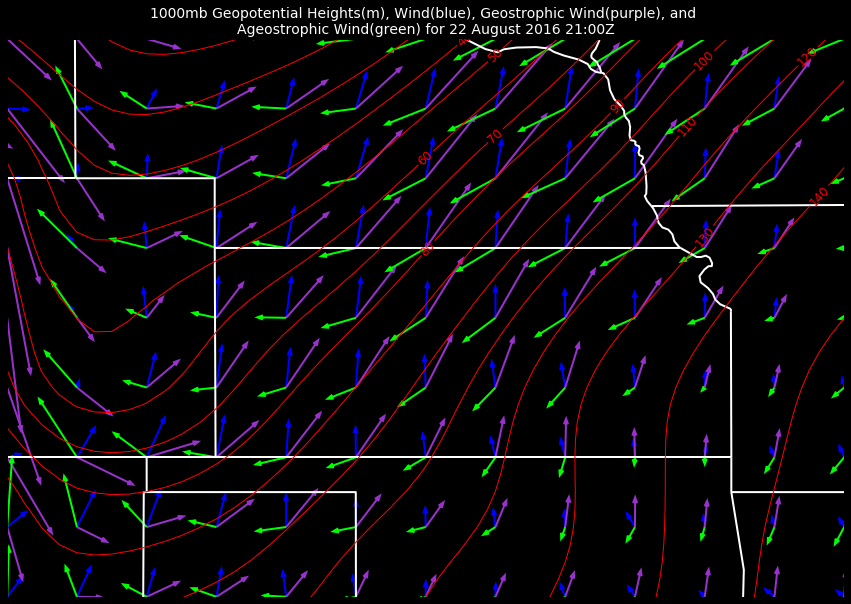

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create new figure
fig = plt.figure(figsize=(15,10), facecolor='black')

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-105., -93., 35., 43.])
ax.background_patch.set_fill(False)

# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='white', linewidth=2)

# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                               scale='50m',facecolor='none')
ax.add_feature(country_borders, edgecolor='white', linewidth=2)

# Contour the pressures every 10 m
contours = np.arange(10, 200, 10)
c = ax.contour(lon_2d, lat_2d, height, levels=contours, colors='red', linewidth=4)
ax.clabel(c, fontsize=12, inline=1, inline_spacing=3, fmt='%i')

# Set up parameters for quiver plot. The slices below are used to subset the data (here
# taking every 4th point in x and y). The quiver_kwargs are parameters to control the
# appearance of the quiver so that they stay consistent between the calls.
quiver_slices = (slice(None, None, 4), slice(None, None, 4))
quiver_kwargs = dict(headlength=4, headwidth=3, angles='uv', scale_units='xy', scale=20)

# Plot the wind vectors
wind = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 u_wind[quiver_slices], v_wind[quiver_slices],
                 color='blue', **quiver_kwargs)
geo = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                geo_wind_u[quiver_slices], geo_wind_v[quiver_slices],
                color='darkorchid', **quiver_kwargs)
ageo = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 ageo_wind_u[quiver_slices], ageo_wind_v[quiver_slices],
                 color='lime', **quiver_kwargs)

# Add a title to the plot
plt.title('1000mb Geopotential Heights(m), Wind(blue), Geostrophic Wind(purple), and \n'
          'Ageostrophic Wind(green) for {0:%d %B %Y %H:%MZ}'.format(time),
          color='white', size=14)